# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.054752,True,4.018649
1,0.144189,False,-0.781169
2,2.868603,True,8.616429
3,-0.463310,False,-1.514361
4,0.776193,True,6.969184
...,...,...,...
995,1.706985,True,7.057593
996,0.458134,False,1.648011
997,-0.629482,True,4.457669
998,0.795582,True,7.531486


<AxesSubplot: xlabel='v0'>

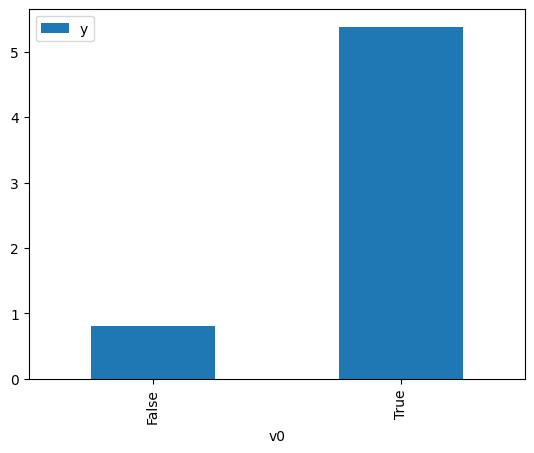

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

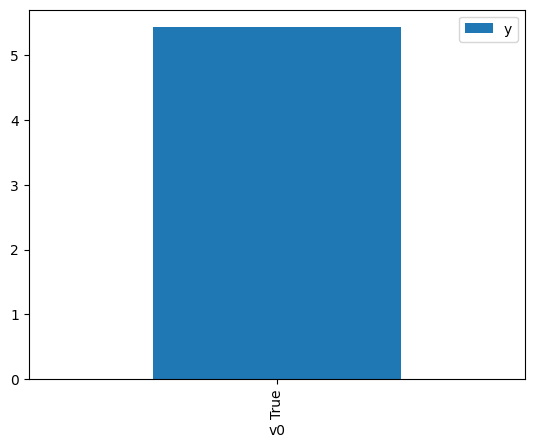

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.593268,False,1.091660,0.119529,8.366180
1,1.162490,False,1.484875,0.190742,5.242682
2,1.105720,False,1.751896,0.202218,4.945163
3,1.329411,False,3.165570,0.159900,6.253918
4,0.029374,False,1.932450,0.501500,1.994017
...,...,...,...,...,...
995,-1.886579,False,-2.155550,0.921274,1.085453
996,0.196574,False,0.006092,0.448153,2.231379
997,-0.113802,False,0.757758,0.547201,1.827482
998,-0.338291,False,-2.089002,0.617010,1.620720


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.382532,True,6.126781,0.369693,2.704947
1,-0.286197,True,7.072886,0.398875,2.507054
2,-0.776090,True,2.663328,0.261619,3.822347
3,0.824402,True,6.492423,0.733451,1.363418
4,0.073189,True,3.192765,0.512526,1.951121
...,...,...,...,...,...
995,1.949493,True,7.720540,0.920789,1.086025
996,0.445166,True,5.276328,0.628669,1.590663
997,1.287004,True,6.980185,0.832669,1.200957
998,0.365441,True,3.582050,0.604537,1.654159


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.163e+04
Date:                Tue, 10 Jan 2023   Prob (F-statistic):                        0.00
Time:                        14:52:01   Log-Likelihood:                         -1372.5
No. Observations:                1000   AIC:                                      2749.
Df Residuals:                     998   BIC:                                      2759.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3819      0.035     39.901      0.000       1.314       1.450
x2             4.9676      0.047    105.435      0.000       4.875       5.060
==============================================================================
Omnibus:                        0.745   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.689   Jarque-Bera (JB):                0.811
Skew:                           0.061   Prob(JB):                        0.666
Kurtosis:                       2.931   Cond. No.                         1.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""